# Critical Price Levels Identifier:

Used FinDiff, NumPy and pandas library to identify key levels in price data using calculus.
- Wrote an algorithm which identifies key points in price data if they can be categorized as a minimum or maximum value.
> get_extrema(isMin) function
- Created lowerbounds and upperbounds to group extrema falling within the same desired range
> Allows the algorithm to count the amount of times price touches particular extrema points, providing a useful measurement for price sensitivity at the corresponding points

### Importing Apple price data

,Date,Close
0,2020-07-21,97.000000
1,2020-07-22,97.272499
2,2020-07-23,92.845001
3,2020-07-24,92.614998
4,2020-07-27,94.809998
...,...,...
248,2021-07-15,148.479996
249,2021-07-16,146.389999
250,2021-07-19,142.449997
251,2021-07-20,146.149994


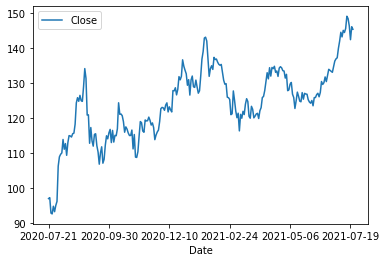

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean

appl = pd.read_csv('AAPL.csv')
appl_line = appl.plot.line('Date', 'Close')



indexed_close = appl[['Date', 'Close']]
clean_indexed_close = indexed_close.transpose()
clean_indexed_close
indexed_close

### Importing FinDiff and differentiating Price with respect to X (Date)

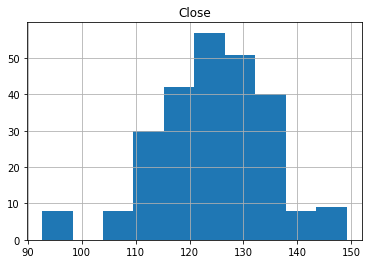

In [2]:
from findiff import FinDiff

h = appl['Close']
hist = appl.hist('Close')

# Setting duration of dx = 1 (1 unit of time) in this case 1 day (daily price data)
dx = 1 

# Taking first order derivative
d_dx = FinDiff(0, dx, 1)

# Taking second order derivative
d2_dx2 = FinDiff(0, dx, 2)

# Converting History of Closes to Array
clarr = np.asarray(h)

# Defining Price Velocity
mom = d_dx(clarr)

# Defining Price Acceleration
momacc = d2_dx2(clarr)

### Function to Identify Critical Points in Price
> get_extrema(isMin)

In [3]:
# Getting Extrema
# Takes in list of indexed closed prices and returns minima and maxima values

def get_extrema(isMin):

    # Applying to all values in time range & defining conditions for extrema
    
    return [x for x in range(len(mom))
"""
If acceleration is either positive (minima) or acceleration is negative (maxima) 
and one of the conditions is met the function will return values for the range
"""
            # Acceleration condition
            if (momacc[x] > 0 if isMin else momacc[x] < 0) and 
            
            # Velocity Possibilities:
"""
1) [Velocity = 0] OR [ x is not the last value AND
2) Velocity(x) > 0 and Velocity(x+1) < 0 AND height(x) >= height(x+1)
- This would indicate a maxima at time x
3) Velocity(x) < 0 and Velocity(x+1) > 0 AND height(x) =< height(x+1)
- This would indicate a minima at time x ]

OR [ x =/= 0 (not first value) AND 
4) velocity(x-1) > 0 and velocity(x) < 0 AND height(x-1) < height(x)
- The would indicate a minima at time x
5) velocity(x-1) < 0 and velocity(x) > 0 AND height(x-1) > height(x)
- This would indicate a maxima at time x ]
"""
            
            (mom[x] == 0 or (x != len(mom) - 1 and
              (mom[x] > 0 and mom[x+1] < 0 and
               h[x] >= h[x+1] or
               mom[x] < 0 and
               mom[x+1] > 0 and
               h[x] <= h[x+1]) or
              x != 0 and
              (mom[x-1] > 0 and
               mom[x] < 0 and
               h[x-1] < h[x] or
               mom[x-1] < 0 and
               mom[x] > 0 and
               h[x-1] > h[x])))]

"""
Positive Accelerations with conditions : get_extrema(True) return minima
Negative Accelerations with conditions : get_extrema(False) return maxima
"""

minimaIdxs, maximaIdxs = get_extrema(True), get_extrema(False)
"""
# Return All Extrema : extrema = minima + maxima
"""
minima_maxima = minimaIdxs + maximaIdxs

### Calculating significance of extrema and visualizing results

In [4]:
# Adding Extrema to Dataframe

levels = pd.DataFrame(h.iloc[np.array(minima_maxima)-1])
levels.columns = ['extrema']

In [5]:
# Adding lowerbounds and upperbounds to find and count overlapping extrema

levels['lower'] = levels['extrema'] * 0.99
levels['upper'] = levels['extrema'] * 1.01

In [6]:
# Measuring the significance of the critical level by measuring the extrema within the lower and upperbounds
# Returning the mean as the new "extrema value" combining ones in the count

grpby = levels.groupby(pd.cut(levels['extrema'], np.arange(levels['extrema'].min(),\
                                                   levels['extrema'].max(), 2)))['extrema'].agg(['mean','count'])#.dropna()
grpby[grpby['count'] > 2]

,mean,count
extrema,,
"(108.845, 110.845]",109.835625,4
"(110.845, 112.845]",112.452500,3
"(112.845, 114.845]",113.173332,3
"(114.845, 116.845]",115.762500,11
"(118.845, 120.845]",119.657999,5
"(120.845, 122.845]",121.743334,9
"(122.845, 124.845]",124.183125,8
"(124.845, 126.845]",125.415000,8
"(126.845, 128.845]",127.849999,6


In [7]:
# Selecting extrema with only 2 counts or more

srlines = grpby[grpby['count'] > 2]['mean'].values

In [8]:
# Creating Range for Graph

start = pd.to_datetime(appl.index.min())
idx = pd.date_range(start, periods= 365)
df = pd.DataFrame({'0':[srlines[0]] * 365})
df.index = idx

for i in range(len(srlines)):
    df[str(i)] = srlines[i]

In [9]:
len(idx), len(appl), len(df)

(365, 253, 365)

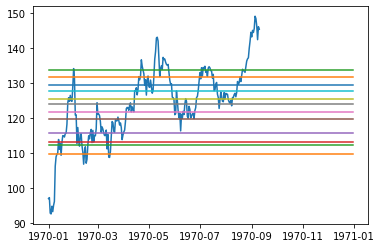

In [10]:
# Visualizing Extrema Found by get_extrema(isMin)

plt.figure()
plt.plot(appl['Close'])
for i in df.columns:
    plt.plot(df[i])
plt.show()